In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")
 # -0.08

Qubit(RO_LO_pwr=16, ge_ssm=-0.1144, ef_time=49, qubit_id=q1, ef_ssm=-0.2568, ge_amp=1, ro_freq=6.72739, RO_IF=None, qubit_thr=[-10000, -600], ef_amp=1.48, ro_amp=0.15, RO_LO=6.6247, ro_dur=5000, ge_time=82, IQ_angle=110, ROIF=0.10268999999999995)
Qubit(RO_LO_pwr=16, ge_ssm=-0.154, ef_time=None, qubit_id=q2, ef_ssm=-0.2962, ge_amp=0.8, ro_freq=6.65554, RO_IF=None, qubit_thr=[-10000, 1900], ef_amp=1, ro_amp=0.7, RO_LO=6.6247, ro_dur=5000, ge_time=54, IQ_angle=25, ROIF=0.030840000000000423)


In [ ]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_amp"],
    bnc_addr=bnc_address["big_agilent"],
)

In [4]:
def run_rabi(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ge(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 10.913577 sec
Captured 33 buffers (3.023757 buffers per sec)
Captured 101376 records (9288.980071 records per sec)
Transferred 1660944384 bytes (152190649.487267 bytes per sec)


<Figure size 800x800 with 0 Axes>

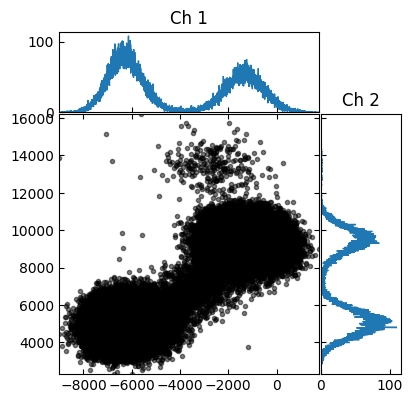

<Figure size 800x800 with 0 Axes>

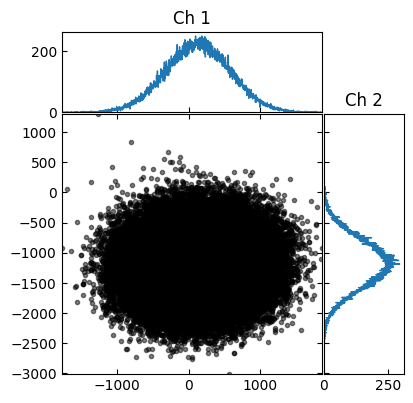

In [5]:
num_steps = 101
reps = 1000
sweep_time = 500
values, IQ_df = run_rabi(q2,q1,general_vals_dict,num_steps, sweep_time, reps)

I


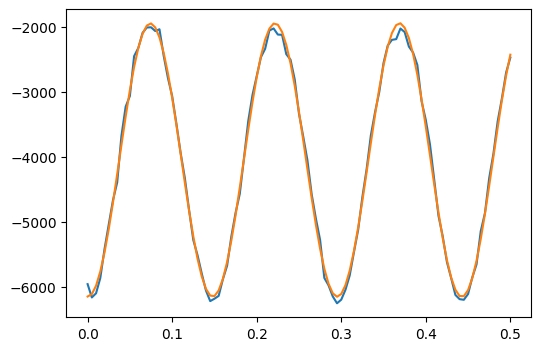



  freq: 6.7872717794106645 +/- 0.006206687411454669
 gamma: -0.005254787934021021 +/- 0.040525541363717506
   amp: -2098.311327012542 +/- 24.021656332656466
 phase: 88.54535841846565 +/- 0.6646369659886657
offset: -4047.6313473929745 +/- 8.65172513987544
pi_pulse time: 0.0736673020103248 +/- 0.006206687411454669
π_ge time = 73.6673020103248 ns


In [7]:
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
if Qrange > Irange:
    print("Q")
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, Q, guess_vals=[11, 0.3, np.abs(np.max(Q) - np.min(Q)), 38, Q[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:
    print("I")
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, I, guess_vals=[11, 0.3, np.abs(np.max(I) - np.min(I)), 38, I[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))